# Load dataset

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=ede2bfe68cdf24add758dbdd7da121dee0a47febd7552e45ef0a9aef5387b07a
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np

import medmnist
from medmnist import INFO, Evaluator

In [4]:
data_flag = 'breastmnist'
# [tissuemnist, pathmnist, chestmnist, dermamnist, octmnist, 
# pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 10
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
import torchvision
from torchvision.transforms.transforms import Resize
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 6625701.18it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz


# Import model

In [6]:
!git clone https://github.com/Omid-Nejati/MedViT.git

Cloning into 'MedViT'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 185 (delta 92), reused 134 (delta 61), pack-reused 1 (from 1)
Receiving objects: 100% (185/185), 823.28 KiB | 7.42 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [7]:
cd ./MedViT

/kaggle/working/MedViT


In [8]:
!pip install timm
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00


In [10]:
from MedViT import MedViT_small as tiny
model = tiny()
model.proj_head[0] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
model = model.cuda()     

initialize_weights...


# Train

In [31]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    print('Epoch [%d/%d]'% (epoch+1, NUM_EPOCHS))
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

Epoch [1/10]


100%|██████████| 55/55 [00:20<00:00,  2.71it/s]


Epoch [2/10]


100%|██████████| 55/55 [00:20<00:00,  2.68it/s]


Epoch [3/10]


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


Epoch [4/10]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


Epoch [5/10]


100%|██████████| 55/55 [00:20<00:00,  2.68it/s]


Epoch [6/10]


100%|██████████| 55/55 [00:20<00:00,  2.68it/s]


Epoch [7/10]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


Epoch [8/10]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


Epoch [9/10]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


Epoch [10/10]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


# Test

In [32]:
def test(split):
    model.eval()
    y_true = torch.tensor([]).cuda()
    y_score = torch.tensor([]).cuda()
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.930  acc:0.883
test  auc: 0.898  acc:0.859


# Try visualization techniques

In [13]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 386 (delta 3), reused 6 (delta 2), pack-reused 377 (from 1)
Receiving objects: 100% (386/386), 3.85 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [14]:
cd ./Transformer-Explainability

/kaggle/working/MedViT/Transformer-Explainability


In [23]:
class Baselines:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def generate_cam_attn(self, input, index=None):
        output = self.model(input.cuda())
        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
        #################### attn
        grad = self.model.blocks[-1].attn.get_attn_gradients()
        cam = self.model.blocks[-1].attn.get_attention_map()
        cam = cam[0, :, 0, 1:].reshape(-1, 14, 14)
        grad = grad[0, :, 0, 1:].reshape(-1, 14, 14)
        grad = grad.mean(dim=[1, 2], keepdim=True)
        cam = (cam * grad).mean(0).clamp(min=0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam
        ####################

In [24]:
# from baselines.ViT.ViT_explanation_generator import Baselines
b = Baselines(model)

def visualize_CAM(input_image, class_index=None):
    # return overlaid_image
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

In [25]:
cat = visualize_CAM(test_dataset[10][0])

AttributeError: 'MedViT' object has no attribute 'blocks'

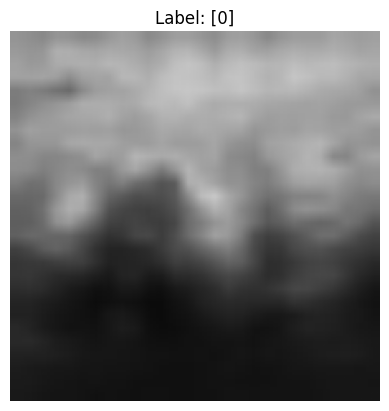

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single sample from the test dataset
sample_image, sample_label = test_dataset[10]  # Index 0, you can change this to visualize other images

# Convert the tensor image to a numpy array for visualization
# The image tensor shape is [C, H, W] so we need to permute it to [H, W, C] for visualization
sample_image_np = sample_image.permute(1, 2, 0).numpy()

# Normalize the image back to [0, 1] for proper visualization
sample_image_np = (sample_image_np * 0.5) + 0.5  # Reversing normalization: (x * std) + mean

# Plot the image
plt.imshow(sample_image_np)
plt.title(f"Label: {sample_label}")  # Display the label as title
plt.axis('off')  # Hide axis for better visualization
plt.show()


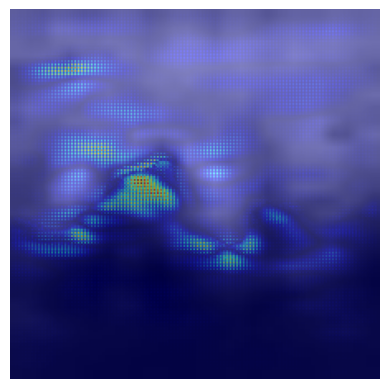

In [23]:
from baselines.ViT.ViT_explanation_generator import LRP

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

attribution_generator = LRP(model)

def generate_saliency_visualization(original_image, class_index=None):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0)[0]  # Change dim=1 to dim=0 and remove keepdim=True
    saliency = saliency.cpu().numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())

    vis = show_cam_on_image(image_transformer_attribution, saliency)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

saliency_result = generate_saliency_visualization(test_dataset[10][0])
plt.imshow(saliency_result)
plt.axis('off')  # Hide axis for better visualization
plt.show()

In [24]:
def generate_visualization_LRP(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

lrp_result = generate_visualization_LRP(test_dataset[10][0])
plt.imshow(lrp_result)
plt.axis('off')  # Hide axis for better visualization
plt.show()

AttributeError: 'MedViT' object has no attribute 'relprop'

# Reimplement attention modules from MedVit to capture attention

In [25]:
from functools import partial
import math
import torch
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model
from torch import nn
from utils import merge_pre_bn

NORM_EPS = 1e-5


class ConvBNReLU(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            groups=1):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                              padding=1, groups=groups, bias=False)
        self.norm = nn.BatchNorm2d(out_channels, eps=NORM_EPS)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class PatchEmbed(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1):
        super(PatchEmbed, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        if stride == 2:
            self.avgpool = nn.AvgPool2d((2, 2), stride=2, ceil_mode=True, count_include_pad=False)
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        elif in_channels != out_channels:
            self.avgpool = nn.Identity()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        else:
            self.avgpool = nn.Identity()
            self.conv = nn.Identity()
            self.norm = nn.Identity()

    def forward(self, x):
        return self.norm(self.conv(self.avgpool(x)))

In [26]:
class MHCA(nn.Module):
    def __init__(self, out_channels, head_dim):
        super(MHCA, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        self.group_conv3x3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                                       padding=1, groups=out_channels // head_dim, bias=False)
        self.norm = norm_layer(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.projection = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)

        # Hooks for attention
        self.attention_map = None
        self.gradients = None

    def save_attention_map(self, grad):
        self.gradients = grad

    def forward(self, x):
        out = self.group_conv3x3(x)
        out = self.norm(out)
        
        # Ensure out.requires_grad is True
        if not out.requires_grad:
            out.requires_grad_()

        self.attention_map = out.clone()  # Save attention
        out.register_hook(self.save_attention_map)  # Hook for gradients
        out = self.act(out)
        out = self.projection(out)
        return out


In [27]:
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class ECALayer(nn.Module):
    def __init__(self, channel, gamma=2, b=1, sigmoid=True):
        super(ECALayer, self).__init__()
        t = int(abs((math.log(channel, 2) + b) / gamma))
        k = t if t % 2 else t + 1

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=k // 2, bias=False)
        if sigmoid:
            self.sigmoid = nn.Sigmoid()
        else:
            self.sigmoid = h_sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2))
        y = y.transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction),
                nn.ReLU(inplace=True),
                nn.Linear(channel // reduction, channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class LocalityFeedForward(nn.Module):
    def __init__(self, in_dim, out_dim, stride, expand_ratio=4., act='hs+se', reduction=4,
                 wo_dp_conv=False, dp_first=False):
        """
        :param in_dim: the input dimension
        :param out_dim: the output dimension. The input and output dimension should be the same.
        :param stride: stride of the depth-wise convolution.
        :param expand_ratio: expansion ratio of the hidden dimension.
        :param act: the activation function.
                    relu: ReLU
                    hs: h_swish
                    hs+se: h_swish and SE module
                    hs+eca: h_swish and ECA module
                    hs+ecah: h_swish and ECA module. Compared with eca, h_sigmoid is used.
        :param reduction: reduction rate in SE module.
        :param wo_dp_conv: without depth-wise convolution.
        :param dp_first: place depth-wise convolution as the first layer.
        """
        super(LocalityFeedForward, self).__init__()
        hidden_dim = int(in_dim * expand_ratio)
        kernel_size = 3

        layers = []
        # the first linear layer is replaced by 1x1 convolution.
        layers.extend([
            nn.Conv2d(in_dim, hidden_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            h_swish() if act.find('hs') >= 0 else nn.ReLU6(inplace=True)])

        # the depth-wise convolution between the two linear layers
        if not wo_dp_conv:
            dp = [
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, kernel_size // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if act.find('hs') >= 0 else nn.ReLU6(inplace=True)
            ]
            if dp_first:
                layers = dp + layers
            else:
                layers.extend(dp)

        if act.find('+') >= 0:
            attn = act.split('+')[1]
            if attn == 'se':
                layers.append(SELayer(hidden_dim, reduction=reduction))
            elif attn.find('eca') >= 0:
                layers.append(ECALayer(hidden_dim, sigmoid=attn == 'eca'))
            else:
                raise NotImplementedError('Activation type {} is not implemented'.format(act))

        # the second linear layer is replaced by 1x1 convolution.
        layers.extend([
            nn.Conv2d(hidden_dim, out_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_dim)
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        x = x + self.conv(x)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, out_features=None, mlp_ratio=None, drop=0., bias=True):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = _make_divisible(in_features * mlp_ratio, 32)
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=1, bias=bias)
        self.act = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(hidden_dim, out_features, kernel_size=1, bias=bias)
        self.drop = nn.Dropout(drop)

    def merge_bn(self, pre_norm):
        merge_pre_bn(self.conv1, pre_norm)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        return x


class ECB(nn.Module):
    """
    Efficient Convolution Block
    """
    def __init__(self, in_channels, out_channels, stride=1, path_dropout=0,
                 drop=0, head_dim=32, mlp_ratio=3):
        super(ECB, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        assert out_channels % head_dim == 0

        self.patch_embed = PatchEmbed(in_channels, out_channels, stride)
        self.mhca = MHCA(out_channels, head_dim)
        self.attention_path_dropout = DropPath(path_dropout)

        self.conv = LocalityFeedForward(out_channels, out_channels, 1, mlp_ratio, reduction=out_channels)

        self.norm = norm_layer(out_channels)
        #self.mlp = Mlp(out_channels, mlp_ratio=mlp_ratio, drop=drop, bias=True)
        #self.mlp_path_dropout = DropPath(path_dropout)
        self.is_bn_merged = False

    def merge_bn(self):
        if not self.is_bn_merged:
            self.mlp.merge_bn(self.norm)
            self.is_bn_merged = True

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.attention_path_dropout(self.mhca(x))
        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm(x)
        else:
            out = x
        #x = x + self.mlp_path_dropout(self.mlp(out))
        x = x + self.conv(out) # (B, dim, 14, 14)
        return x

In [28]:
class E_MHSA(nn.Module):
    """
    Efficient Multi-Head Self Attention with attention map and gradient hooks for CAM.
    """
    def __init__(self, dim, out_dim=None, head_dim=32, qkv_bias=True, qk_scale=None,
                 attn_drop=0, proj_drop=0., sr_ratio=1):
        super().__init__()
        self.dim = dim
        self.out_dim = out_dim if out_dim is not None else dim
        self.num_heads = self.dim // head_dim
        self.scale = qk_scale or head_dim ** -0.5
        self.q = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.k = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.v = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.proj = nn.Linear(self.dim, self.out_dim)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        self.N_ratio = sr_ratio ** 2
        if sr_ratio > 1:
            self.sr = nn.AvgPool1d(kernel_size=self.N_ratio, stride=self.N_ratio)
            self.norm = nn.BatchNorm1d(dim, eps=NORM_EPS)
        self.is_bn_merged = False

        # Attributes to store attention map and gradients
        self.attention_map = None
        self.attention_map_grad = None

    def merge_bn(self, pre_bn):
        merge_pre_bn(self.q, pre_bn)
        if self.sr_ratio > 1:
            merge_pre_bn(self.k, pre_bn, self.norm)
            merge_pre_bn(self.v, pre_bn, self.norm)
        else:
            merge_pre_bn(self.k, pre_bn)
            merge_pre_bn(self.v, pre_bn)
        self.is_bn_merged = True

    def forward(self, x):
        B, N, C = x.shape
        q = self.q(x)
        q = q.reshape(B, N, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)
        
        if self.sr_ratio > 1:
            x_ = x.transpose(1, 2)
            x_ = self.sr(x_)
            if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
                x_ = self.norm(x_)
            x_ = x_.transpose(1, 2)
            k = self.k(x_)
            k = k.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 3, 1)
            v = self.v(x_)
            v = v.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)
        else:
            k = self.k(x)
            k = k.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 3, 1)
            v = self.v(x)
            v = v.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)
        attn = (q @ k) * self.scale
    
        # Enable gradient tracking for the attention map
        attn.requires_grad_()
    
        # Store the attention map
        self.attention_map = attn
    
        # Register hooks after the attention map is created
        self.register_hooks()
    
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
    
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


    def get_attention_map(self):
        """Retrieve the attention map (requires forward pass)."""
        return self.attention_map

    def get_attention_grad(self):
        """Retrieve the attention map gradients (requires backward pass)."""
        return self.attention_map_grad

    def register_hooks(self):
        """Register hooks to store attention map gradients during backpropagation."""
        def save_gradients(grad):
            self.attention_map_grad = grad

        self.attention_map.register_hook(save_gradients)


In [29]:
class LTB(nn.Module):
    """
    Local Transformer Block
    """
    def __init__(
            self, in_channels, out_channels, path_dropout, stride=1, sr_ratio=1,
            mlp_ratio=2, head_dim=32, mix_block_ratio=0.75, attn_drop=0, drop=0,
    ):
        super(LTB, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mix_block_ratio = mix_block_ratio
        norm_func = partial(nn.BatchNorm2d, eps=NORM_EPS)

        self.mhsa_out_channels = _make_divisible(int(out_channels * mix_block_ratio), 32)
        self.mhca_out_channels = out_channels - self.mhsa_out_channels

        self.patch_embed = PatchEmbed(in_channels, self.mhsa_out_channels, stride)
        self.norm1 = norm_func(self.mhsa_out_channels)
        self.e_mhsa = E_MHSA(self.mhsa_out_channels, head_dim=head_dim, sr_ratio=sr_ratio,
                             attn_drop=attn_drop, proj_drop=drop)
        self.mhsa_path_dropout = DropPath(path_dropout * mix_block_ratio)

        self.projection = PatchEmbed(self.mhsa_out_channels, self.mhca_out_channels, stride=1)
        self.mhca = MHCA(self.mhca_out_channels, head_dim=head_dim)
        self.mhca_path_dropout = DropPath(path_dropout * (1 - mix_block_ratio))

        self.norm2 = norm_func(out_channels)
        self.conv = LocalityFeedForward(out_channels, out_channels, 1, mlp_ratio, reduction=out_channels)

        #self.mlp = Mlp(out_channels, mlp_ratio=mlp_ratio, drop=drop)
        #self.mlp_path_dropout = DropPath(path_dropout)

        self.is_bn_merged = False

    def merge_bn(self):
        if not self.is_bn_merged:
            self.e_mhsa.merge_bn(self.norm1)
            self.mlp.merge_bn(self.norm2)
            self.is_bn_merged = True

    def forward(self, x):
        x = self.patch_embed(x)
        B, C, H, W = x.shape
        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm1(x)
        else:
            out = x
        out = rearrange(out, "b c h w -> b (h w) c")  # b n c
        out = self.mhsa_path_dropout(self.e_mhsa(out))
        x = x + rearrange(out, "b (h w) c -> b c h w", h=H)

        out = self.projection(x)
        out = out + self.mhca_path_dropout(self.mhca(out))
        x = torch.cat([x, out], dim=1)

        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm2(x)
        else:
            out = x
        x = x + self.conv(out)
        #x = x + self.mlp_path_dropout(self.mlp(out))
        return x


class MedViT(nn.Module):
    def __init__(self, stem_chs, depths, path_dropout, attn_drop=0, drop=0, num_classes=1000,
                 strides=[1, 2, 2, 2], sr_ratios=[8, 4, 2, 1], head_dim=32, mix_block_ratio=0.75,
                 use_checkpoint=False):
        super(MedViT, self).__init__()
        self.use_checkpoint = use_checkpoint

        self.stage_out_channels = [[96] * (depths[0]),
                                   [192] * (depths[1] - 1) + [256],
                                   [384, 384, 384, 384, 512] * (depths[2] // 5),
                                   [768] * (depths[3] - 1) + [1024]]

        # Next Hybrid Strategy
        self.stage_block_types = [[ECB] * depths[0],
                                  [ECB] * (depths[1] - 1) + [LTB],
                                  [ECB, ECB, ECB, ECB, LTB] * (depths[2] // 5),
                                  [ECB] * (depths[3] - 1) + [LTB]]

        self.stem = nn.Sequential(
            ConvBNReLU(3, stem_chs[0], kernel_size=3, stride=2),
            ConvBNReLU(stem_chs[0], stem_chs[1], kernel_size=3, stride=1),
            ConvBNReLU(stem_chs[1], stem_chs[2], kernel_size=3, stride=1),
            ConvBNReLU(stem_chs[2], stem_chs[2], kernel_size=3, stride=2),
        )
        input_channel = stem_chs[-1]
        features = []
        idx = 0
        dpr = [x.item() for x in torch.linspace(0, path_dropout, sum(depths))]  # stochastic depth decay rule
        for stage_id in range(len(depths)):
            numrepeat = depths[stage_id]
            output_channels = self.stage_out_channels[stage_id]
            block_types = self.stage_block_types[stage_id]
            for block_id in range(numrepeat):
                if strides[stage_id] == 2 and block_id == 0:
                    stride = 2
                else:
                    stride = 1
                output_channel = output_channels[block_id]
                block_type = block_types[block_id]
                if block_type is ECB:
                    layer = ECB(input_channel, output_channel, stride=stride, path_dropout=dpr[idx + block_id],
                                drop=drop, head_dim=head_dim)
                    features.append(layer)
                elif block_type is LTB:
                    layer = LTB(input_channel, output_channel, path_dropout=dpr[idx + block_id], stride=stride,
                                sr_ratio=sr_ratios[stage_id], head_dim=head_dim, mix_block_ratio=mix_block_ratio,
                                attn_drop=attn_drop, drop=drop)
                    features.append(layer)
                input_channel = output_channel
            idx += numrepeat
        self.features = nn.Sequential(*features)

        self.norm = nn.BatchNorm2d(output_channel, eps=NORM_EPS)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj_head = nn.Sequential(
            nn.Linear(output_channel, num_classes),
        )

        self.stage_out_idx = [sum(depths[:idx + 1]) - 1 for idx in range(len(depths))]
        print('initialize_weights...')
        self._initialize_weights()

    def merge_bn(self):
        self.eval()
        for idx, module in self.named_modules():
            if isinstance(module, ECB) or isinstance(module, LTB):
                module.merge_bn()

    def _initialize_weights(self):
        for n, m in self.named_modules():
            if isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        for idx, layer in enumerate(self.features):
            if self.use_checkpoint:
                x = checkpoint.checkpoint(layer, x)
            else:
                x = layer(x)
        x = self.norm(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.proj_head(x)
        return x


@register_model
def MedViT_small(pretrained=False, pretrained_cfg=None, **kwargs):
    model = MedViT(stem_chs=[64, 32, 64], depths=[3, 4, 10, 3], path_dropout=0.1, **kwargs)
    return model

/tmp/ipykernel_30/3341103481.py:164: UserWarning: Overwriting MedViT_small in registry with __main__.MedViT_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def MedViT_small(pretrained=False, pretrained_cfg=None, **kwargs):


In [30]:
model = MedViT_small()
model.proj_head[0] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
model = model.cuda()

initialize_weights...


In [38]:
class Baselines:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def generate_cam_attn(self, input, index=None):
        output = self.model(input.cuda())
        if index is None:
            index = torch.argmax(output, dim=1).item()
    
        one_hot = torch.zeros_like(output)
        one_hot[0, index] = 1
        one_hot = one_hot.requires_grad_(True)
        one_hot = torch.sum(one_hot * output)
    
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
    
        # Retrieve attention map and gradients from MHCA
        cam, grad = None, None
        for block in self.model.features:
            if isinstance(block, ECB) or isinstance(block, LTB):
                if hasattr(block.mhca, 'attention_map') and block.mhca.attention_map is not None:
                    cam = block.mhca.attention_map  # Shape: [B, C, H, W]
                    grad = block.mhca.gradients     # Shape: [B, C, H, W]
                    break

        if cam is None or grad is None:
            raise ValueError("Attention map or gradients not found!")
    
        # Collapse channel dimension for cam
        cam = cam.mean(dim=1, keepdim=True)  # Shape: [B, 1, H, W]
        grad = grad.mean(dim=[2, 3], keepdim=True)  # Global average pooling for gradients
        cam = cam * grad  # Weighted combination
        cam = cam.mean(dim=0).clamp(min=0)  # Collapse batch dimension
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)  # Normalize
        return cam  # Shape: [1, H, W]



b = Baselines(model)

def visualize_CAM(input_image, class_index=None):
    # Generate CAM
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)

    # Upsample CAM to input image size
    h, w = input_image.shape[1], input_image.shape[2]  # Original input spatial dimensions
    transformer_attribution = transformer_attribution.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    transformer_attribution = torch.nn.functional.interpolate(
        transformer_attribution, size=(h, w), mode='bilinear', align_corners=False
    )
    transformer_attribution = transformer_attribution.squeeze().data.cpu().numpy()  # Shape: [H, W]
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (
        transformer_attribution.max() - transformer_attribution.min() + 1e-6
    )

    # Overlay CAM on the original image
    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()  # Shape: [H, W, C]
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (
        image_transformer_attribution.max() - image_transformer_attribution.min() + 1e-6
    )
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis



cam_result = visualize_CAM(test_dataset[10][0])
plt.imshow(cam_result)
plt.axis('off')  # Hide axis for better visualization
plt.show()

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [96, 56, 56] and output size of (224, 224). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.